In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

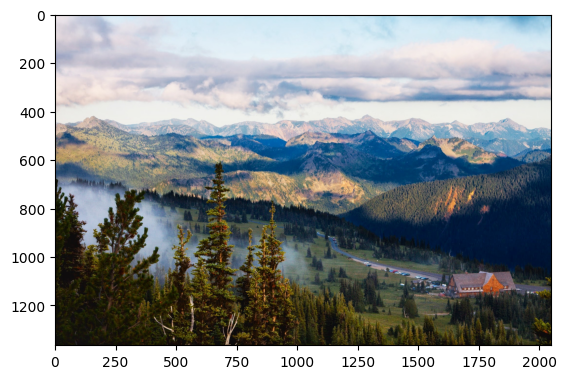

In [2]:
content_img = Image.open('rainier.jpeg').convert('RGB')
plt.imshow(content_img)

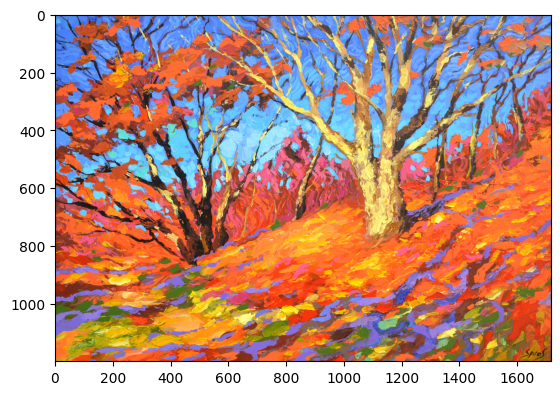

In [3]:
style_img = Image.open('autumn-oak.jpeg').convert('RGB')
plt.imshow(style_img)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# standard mean and std from ImageNet
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

In [6]:
def preprocess(img, image_shape):
  transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
  return transforms(img).unsqueeze(0)

In [7]:
def postprocess(img):
  img = img[0].to(rgb_std.device)
  img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
  return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

# Model

In [8]:
pretrained_net = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 139MB/s]


In [9]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [30]:
model = nn.Sequential(*[pretrained_net.features[i] for i in
                       range(max(content_layers + style_layers) + 1)])

# Feature Extraction

In [45]:
def extract_features(X, content_layers, style_layers):
  contents = []
  styles = []
  for i in range(len(model)):
    X = model[i](X)
    if i in style_layers:
      styles.append(X)
    if i in content_layers:
      contents.append(X)
  return contents, styles

In [46]:
def get_contents(image_shape, device):
  content_X = preprocess(content_img, image_shape).to(device)
  contents_Y, _ = extract_features(content_X, content_layers, style_layers)
  return content_X, contents_Y

In [47]:
def get_styles(image_shape, device):
  style_X = preprocess(style_img, image_shape).to(device)
  _, styles_Y = extract_features(style_X, content_layers, style_layers)
  return style_X, styles_Y

# Losses

**Content Loss**

In [14]:
def content_loss(Y_hat, Y):
  # detach the target content from the tree used to dynamically compute
  # the gradient
  return torch.square(Y_hat - Y.detach()).mean()

**Style Loss**

Gram matrix




In [48]:
def gram(X):
  num_channels, n = X.shape[1], X.numel() // X.shape[1]
  X = X.reshape((num_channels, n))
  return torch.matmul(X, X.T) / (num_channels * n)

In [49]:
def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

**Total Variation Loss**

In [50]:
def tv_loss(Y_hat):
  return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

Compute Loss

In [51]:
content_weight, style_weight, tv_weight = 1, 1e3, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
  # Calculate the content, style, and total variance losses respectively
  contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
      contents_Y_hat, contents_Y)]
  styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
      styles_Y_hat, styles_Y_gram)]
  tv_l = tv_loss(X) * tv_weight
  # Add up all the losses
  l = sum(10 * styles_l + contents_l + [tv_l])
  return contents_l, styles_l, tv_l, l

In [52]:
class SynthesizedImage(nn.Module):
  def __init__(self, img_shape):
    super(SynthesizedImage, self).__init__()
    self.weight = nn.Parameter(torch.rand(*img_shape))
  def forward(self):
    return self.weight

In [53]:
def get_inits(X, device, lr, styles_Y):
  gen_img = SynthesizedImage(X.shape).to(device)
  gen_img.weight.data.copy_(X.data)
  optimizer = optim.Adam(gen_img.parameters(), lr=lr)
  styles_Y_gram = [gram(Y) for Y in styles_Y]
  return gen_img(), styles_Y_gram, optimizer

In [54]:
def use_svg_display():
  """Use svg format to display plot in jupyter."""
  display.set_matplotlib_formats('svg')

In [55]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
  """Set the axes for matplotlib.

  Defined in :numref:`sec_calculus`"""
  axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
  axes.set_xscale(xscale), axes.set_yscale(yscale)
  axes.set_xlim(xlim),     axes.set_ylim(ylim)
  if legend:
    axes.legend(legend)
  axes.grid()

In [56]:
class Animator:
  """For plotting data in animation."""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
    """Defined in :numref:`sec_utils`"""
    # Incrementally plot multiple lines
    if legend is None:
      legend = []
    use_svg_display()
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    # Use a lambda function to capture arguments
    self.config_axes = lambda: set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # Add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

# Training

In [57]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
  X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
  scheduler = optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, 0.8)
  animator = Animator(xlabel='epoch', ylabel='loss',
                      xlim=[10, num_epochs],
                      legend=['content', 'style', 'TV'],
                      ncols=2, figsize=(7, 2.5))
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    contents_Y_hat, styles_Y_hat = extract_features(
      X, content_layers, style_layers)
    contents_l, styles_l, tv_l, l = compute_loss(
      X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
    l.backward()
    optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
      animator.axes[1].imshow(postprocess(X))
      animator.add(epoch + 1, [float(sum(contents_l)),
                              float(sum(styles_l)), float(tv_l)])
  return X

In [58]:
image_shape = (300, 450)
model = model.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)

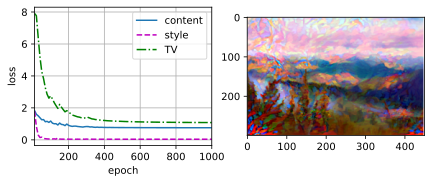

In [59]:
output = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50)